In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from multicopy_STR_genotyping import file_io, str_utils

sns.set_context("poster")
%matplotlib inline

In [3]:
df_segdup_repeats = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", 
                sep="\t", header=None, names=["chr", "start", "end", "period", "unit"])
    .assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])]))
df_pedigree = pd.read_csv("../../data/1000Genomes/1000_genomes_triad_pedigrees_subsamp.csv").drop("Unnamed: 0", axis=1).set_index("sampleID")

df_pedigree.head()

,triadID,role,pgx_id,sex,ENA_FILE_PATH,population
sampleID,,,,,,
HG00421,3,father,onekgbs-HG00421,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00422,3,mother,onekgbs-HG00422,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00423,3,child,onekgbs-HG00423,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,CHS
HG00542,21,father,onekgbs-HG00542,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00543,21,mother,onekgbs-HG00543,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS


In [4]:
bcf_files = !find ../../data/1000Genomes/variants -name "fam_trio_[0-9]*.bcf"
bcf_files

['../../data/1000Genomes/variants/595/fam_trio_595.bcf',
 '../../data/1000Genomes/variants/169/fam_trio_169.bcf',
 '../../data/1000Genomes/variants/447/fam_trio_447.bcf',
 '../../data/1000Genomes/variants/260/fam_trio_260.bcf',
 '../../data/1000Genomes/variants/409/fam_trio_409.bcf',
 '../../data/1000Genomes/variants/143/fam_trio_143.bcf',
 '../../data/1000Genomes/variants/55/fam_trio_55.bcf',
 '../../data/1000Genomes/variants/320/fam_trio_320.bcf',
 '../../data/1000Genomes/variants/3/fam_trio_3.bcf',
 '../../data/1000Genomes/variants/76/fam_trio_76.bcf']

In [5]:
df_repeats, df_samples = [], []
for bcf in bcf_files:
    df_repeats_inner, df_samples_inner = file_io.dfs_from_vcf(bcf)

    trio_id = None
    family = dict()
    for sample in df_samples_inner["sample"].unique():
        if not trio_id:
            trio_id = df_pedigree.loc[sample, "triadID"]
        family[sample] = df_pedigree.loc[sample, "role"]
    if not len(family) == 3:
        raise ValueError(f"Family relationships could not be properly identified: {family}")

    df_samples_inner = df_samples_inner.assign(
        family_id = trio_id,
        role = lambda x: [family[i] for i in x["sample"]])
     
    df_repeats.append(df_repeats_inner)
    df_samples.append(df_samples_inner)

df_repeats = pd.concat(df_repeats).drop_duplicates()
df_samples = pd.concat(df_samples)
df_repeats.shape, df_samples.shape

((33734, 7), (368535, 7))

In [6]:
df_repeats.head()

,str_id,chr,start,end,unit,period,ref
0,chr1_4065397,chr1,4065397,4065408,CACTCA,6,2
1,chr1_4067034,chr1,4067034,4067045,CACTCA,6,2
2,chr1_4067354,chr1,4067354,4067365,CACTCA,6,2
3,chr1_10188308,chr1,10188308,10188319,TA,2,6
4,chr1_10188568,chr1,10188568,10188586,T,1,19


In [7]:
df_samples.head()

,sample,str_id,copy_number,frequencies,genotype,family_id,role
0,NA19908,chr1_4065397,1,{2: 31},[2],595,father
1,NA19909,chr1_4065397,1,{2: 16},[2],595,mother
2,NA19919,chr1_4065397,0,NaN,NaN,595,child
3,NA19908,chr1_4067034,1,{2: 22},[2],595,father
4,NA19909,chr1_4067034,1,{2: 26},[2],595,mother


In [8]:
df_samples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368535 entries, 0 to 34508
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sample       368535 non-null  object
 1   str_id       368535 non-null  object
 2   copy_number  368535 non-null  int32 
 3   frequencies  347883 non-null  object
 4   genotype     338138 non-null  object
 5   family_id    368535 non-null  int64 
 6   role         368535 non-null  object
dtypes: int32(1), int64(1), object(5)
memory usage: 21.1+ MB


For loci where the copy number is 0 according to the supplied CNV file, the genotype is NaN, even though reads may have been mapped. To allow uniform analysis of CN 0 loci, we set the genotype to be an empty list, and the frequencies to an empty dict if no reads are mapped.

In [9]:
df_samples.loc[df_samples["copy_number"] == 0] = (df_samples
                                                  .loc[df_samples["copy_number"] == 0]
                                                  .assign(genotype = lambda x: [[] for i in x["genotype"]]))
df_samples.loc[(df_samples["copy_number"] == 0) & df_samples["frequencies"].isna()] = (
                                                  df_samples
                                                  .loc[(df_samples["copy_number"] == 0) & df_samples["frequencies"].isna()]
                                                  .assign(frequencies = lambda x: [dict() for i in x["frequencies"]]))
df_samples.loc[df_samples["copy_number"] == 0].head()

,sample,str_id,copy_number,frequencies,genotype,family_id,role
2,NA19919,chr1_4065397,0,{},[],595,child
5,NA19919,chr1_4067034,0,{2: 29},[],595,child
8,NA19919,chr1_4067354,0,{},[],595,child
384,NA19908,chr1_67542273,0,"{17: 1, 18: 15}",[],595,father
386,NA19919,chr1_67542273,0,"{17: 7, 18: 11}",[],595,child


This leaves NA values for loci where multiple copy number arrangements are equally likely, even though there are reads mappped. Furthermore, we do not estimate genotypes where the copy number is over 20 (will also be NA). These observations will be filtered out below.

In [10]:
df_samples.loc[(~pd.isna(df_samples["frequencies"])) & (pd.isna(df_samples["genotype"]))]["copy_number"].value_counts()

copy_number
1      1688
39       59
2        57
45       30
32       28
191       6
188       6
51        4
46        4
33        4
63        4
28        3
256       3
176       3
327       3
262       3
318       3
219       3
24        3
237       3
181       3
210       3
242       3
185       3
21        3
252       3
281       3
236       3
276       3
168       3
296       3
178       3
250       3
183       3
152       3
154       3
50        2
34        2
41        2
49        2
22        2
58        2
70        2
26        2
44        2
42        2
54        2
38        2
25        1
Name: count, dtype: int64

In [11]:
def filter_trio_calls(df_samples: pd.DataFrame, segdup_loci: np.array) -> pd.DataFrame:
    # first we drop observations without any reads mapped
    # or where genotype could not be estimated
    df_filt = df_samples.dropna(axis=0, how="any")
    
    # then, drop loci that are located in segmental duplications
    df_filt = df_filt.loc[~df_filt["str_id"].isin(segdup_loci)]
    
    # finally, drop loci that were not observed in all three samples
    observed_in_all = df_filt["str_id"].value_counts().where(lambda x: x == 3).dropna().index
    df_filt = df_filt.loc[df_filt["str_id"].isin(observed_in_all)].reset_index(drop=True)
    
    return df_filt
    

In [36]:
df_samples_filt = []

print(df_samples.shape)
for name, data in df_samples.groupby("family_id"):
    df_samples_filt_inner = filter_trio_calls(data, df_segdup_repeats["str_id"])
    df_samples_filt.append(df_samples_filt_inner)

df_samples_filt = pd.concat(df_samples_filt)

print(df_samples_filt.shape)

df_samples_filt = df_samples_filt.assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_per_cn = lambda x: x["depth"] / x["copy_number"])

# For CN == 0, set depth_per_cn to depth. Not strictly correct but avoids NaNs and infs
df_samples_filt.loc[df_samples_filt["copy_number"] == 0, "depth_per_cn"] = (
    df_samples_filt
    .loc[df_samples_filt["copy_number"] == 0]["depth"])
df_samples_filt.head(12)

(368535, 7)
(121461, 7)


,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn
0,HG00421,chr1_1366512,1,{2: 45},[2],3,father,45,45.0
1,HG00422,chr1_1366512,1,{2: 32},[2],3,mother,32,32.0
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0
3,HG00421,chr1_4067034,2,{2: 25},"[2, 2]",3,father,25,12.5
4,HG00422,chr1_4067034,1,{2: 25},[2],3,mother,25,25.0
5,HG00423,chr1_4067034,2,{2: 26},"[2, 2]",3,child,26,13.0
6,HG00421,chr1_4067354,2,"{2: 36, 3: 1}","[2, 2]",3,father,37,18.5
7,HG00422,chr1_4067354,1,{2: 18},[2],3,mother,18,18.0
8,HG00423,chr1_4067354,2,{2: 32},"[2, 2]",3,child,32,16.0
9,HG00421,chr1_9537182,0,{15: 1},[],3,father,1,1.0


In [35]:
print(df_samples_filt.query("copy_number != 0").shape[0])

# mean number of loci per sample that overlap CNV event
df_samples_filt.query("copy_number != 0").shape[0] / df_samples_filt["sample"].nunique()

109190


3639.6666666666665

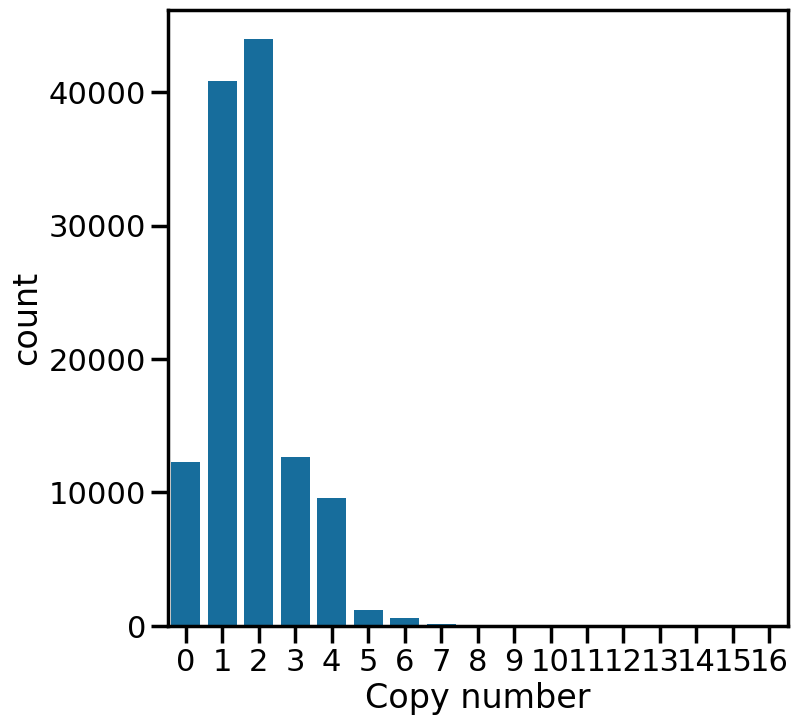

In [13]:
df_samples_filt["copy_number"].value_counts()
fig = plt.figure(figsize=(8, 8))

ax = sns.countplot(
    df_samples_filt,
    x='copy_number',
    color=sns.color_palette("colorblind")[0],
)

_ = ax.set(
    xlabel = "Copy number",
)

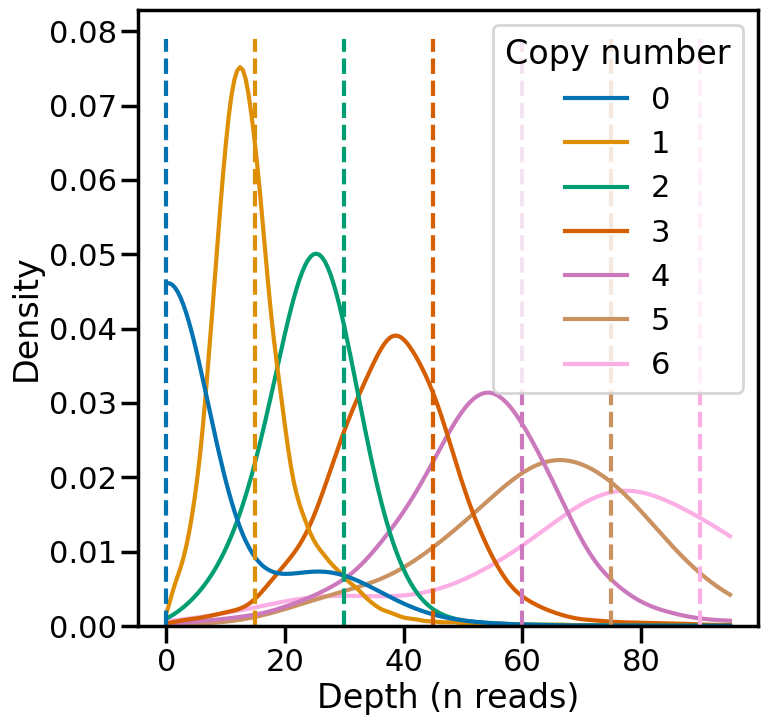

In [14]:
maxdepth = 95
min_cn = 0

fig = plt.figure(figsize=(8, 8))

ax = sns.kdeplot(
    df_samples_filt.query(f"copy_number >= {min_cn} and copy_number <= 6"),
    x = "depth",
    common_norm=False,
    clip=(0, maxdepth),
    hue="copy_number",
    palette="colorblind"
)

ax.set(
    xlabel = "Depth (n reads)",
)

ax.get_legend().set(bbox_to_anchor = (1, 1), title="Copy number")

vlines = np.arange(0, maxdepth, 15)[min_cn:]
ymax = ax.get_ylim()[1]
_ = ax.vlines(
    vlines, 
    ymin = 0, 
    ymax = ymax, 
    linestyle="--", 
    colors=sns.color_palette("colorblind")
)


In [40]:
df_samples_filt["child_gt_possible"] = False

for family, fam_data in df_samples_filt.groupby("family_id"):
    possible_child_gts = []
    for locus, locus_data in fam_data.groupby("str_id"):
        locus_data = locus_data.set_index("role")
        
        child = np.array(locus_data.loc["child", "genotype"])
        p1 = np.array(locus_data.loc["father", "genotype"])
        p2 = np.array(locus_data.loc["mother", "genotype"])

        if str_utils.child_gt_possible(child, p1, p2):
            possible_child_gts.append(locus)

    df_samples_filt.loc[df_samples_filt["family_id"] == family] = df_samples_filt.loc[df_samples_filt["family_id"] == family].assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )
    fam_data = fam_data.assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )
    
    total_loci = fam_data["str_id"].nunique()
    consistent_loci = fam_data.loc[fam_data["child_gt_possible"]]["str_id"].nunique()
    
    print(f"Family {family}:")
    print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
    print()

total_loci = df_samples_filt[["family_id", "str_id", "child_gt_possible"]].drop_duplicates().shape[0]
consistent_loci = df_samples_filt[["family_id", "str_id", "child_gt_possible"]].drop_duplicates().query("child_gt_possible").shape[0]

print(f"Overall:")
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
print()

df_samples_filt.head(30)

Family 3:
3385 out of 3728 loci (90.80%) in the child could have possibly been inherited from the parents

Family 55:
3751 out of 4063 loci (92.32%) in the child could have possibly been inherited from the parents

Family 76:
3211 out of 3731 loci (86.06%) in the child could have possibly been inherited from the parents

Family 143:
3182 out of 3622 loci (87.85%) in the child could have possibly been inherited from the parents

Family 169:
3279 out of 3771 loci (86.95%) in the child could have possibly been inherited from the parents

Family 260:
3580 out of 4083 loci (87.68%) in the child could have possibly been inherited from the parents

Family 320:
4082 out of 4606 loci (88.62%) in the child could have possibly been inherited from the parents

Family 409:
3479 out of 4024 loci (86.46%) in the child could have possibly been inherited from the parents

Family 447:
4009 out of 4510 loci (88.89%) in the child could have possibly been inherited from the parents

Family 595:
3919 out of

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible
0,HG00421,chr1_1366512,1,{2: 45},[2],3,father,45,45.0,True
1,HG00422,chr1_1366512,1,{2: 32},[2],3,mother,32,32.0,True
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0,True
3,HG00421,chr1_4067034,2,{2: 25},"[2, 2]",3,father,25,12.5,True
4,HG00422,chr1_4067034,1,{2: 25},[2],3,mother,25,25.0,True
5,HG00423,chr1_4067034,2,{2: 26},"[2, 2]",3,child,26,13.0,True
6,HG00421,chr1_4067354,2,"{2: 36, 3: 1}","[2, 2]",3,father,37,18.5,True
7,HG00422,chr1_4067354,1,{2: 18},[2],3,mother,18,18.0,True
8,HG00423,chr1_4067354,2,{2: 32},"[2, 2]",3,child,32,16.0,True
9,HG00421,chr1_9537182,0,{15: 1},[],3,father,1,1.0,False


In [16]:
min_depth_per_cn = 0
max_depth_per_cn = 10

print(f"{min_depth_per_cn} >= depth > {max_depth_per_cn}:")
total_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}").shape[0]
consistent_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn} and child_gt_possible").shape[0]
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
print()

min_depth_per_cn = 10
max_depth_per_cn = 15

print(f"{min_depth_per_cn} >= depth > {max_depth_per_cn}:")
total_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}").shape[0]
consistent_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn} and child_gt_possible").shape[0]
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
print()

min_depth_per_cn = 15
max_depth_per_cn = 20

print(f"{min_depth_per_cn} >= depth > {max_depth_per_cn}:")
total_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}").shape[0]
consistent_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn} and child_gt_possible").shape[0]
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
print()

min_depth_per_cn = 20
max_depth_per_cn = 25

print(f"{min_depth_per_cn} >= depth > {max_depth_per_cn}:")
total_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}").shape[0]
consistent_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn} and child_gt_possible").shape[0]
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
print()

min_depth_per_cn = 25
max_depth_per_cn = 30

print(f"{min_depth_per_cn} >= depth > {max_depth_per_cn}:")
total_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}").shape[0]
consistent_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn} and child_gt_possible").shape[0]
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")

0 >= depth > 10:
8339 out of 10296 loci (80.99%) in the child could have possibly been inherited from the parents

10 >= depth > 15:
14887 out of 15937 loci (93.41%) in the child could have possibly been inherited from the parents

15 >= depth > 20:
9157 out of 9773 loci (93.70%) in the child could have possibly been inherited from the parents

20 >= depth > 25:
1826 out of 2203 loci (82.89%) in the child could have possibly been inherited from the parents

25 >= depth > 30:
722 out of 1017 loci (70.99%) in the child could have possibly been inherited from the parents


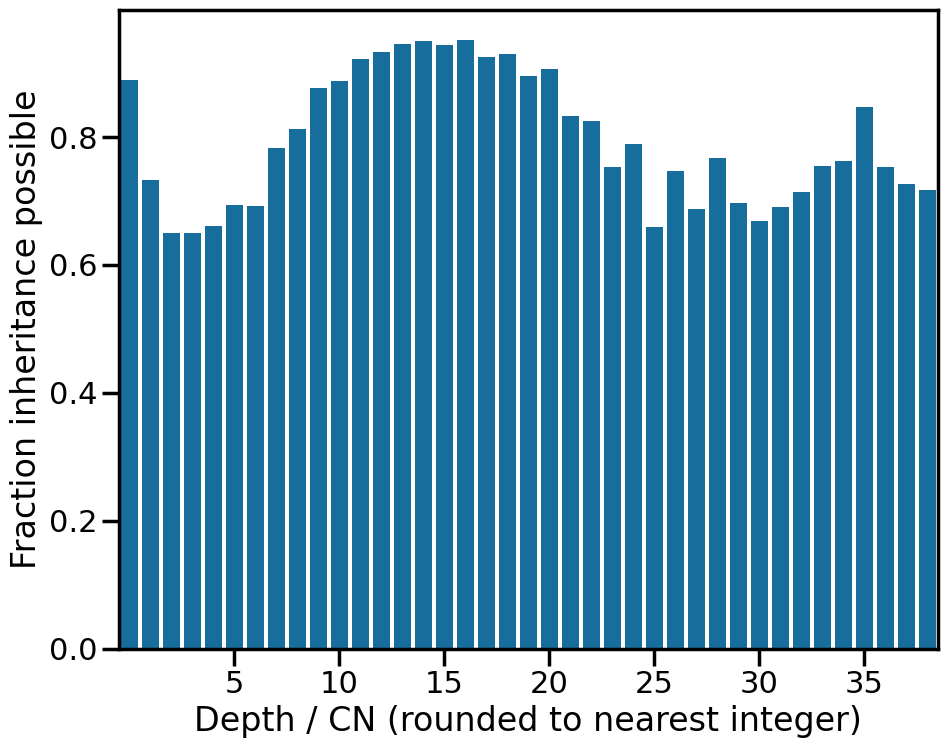

In [17]:
df_plot = (df_samples_filt
           .query("role == 'child'")
           .assign(depth_per_cn_round = lambda x: x["depth_per_cn"].round(0).astype(int))[["depth_per_cn_round", "child_gt_possible"]]
           .groupby(["depth_per_cn_round"], as_index=False)
           .agg(n = ("child_gt_possible", "size"), frac = ("child_gt_possible", lambda x: sum(x) / len(x)))
           .query("n >= 50")
           .reset_index(drop=True))

x_order = pd.Categorical(np.arange(df_plot["depth_per_cn_round"].min(), df_plot["depth_per_cn_round"].max() + 1), ordered=True)

fig = plt.figure(figsize = (10, 8))

ax = sns.barplot(
    df_plot,
    x="depth_per_cn_round",
    y="frac",
    order=x_order,
    color=sns.color_palette("colorblind")[0]
)

_ = ax.set(
    # xticks = np.arange(min(ax.get_xticks()), max(ax.get_xticks()), 5),
    xticks = np.arange(5, max(ax.get_xticks()), 5),
    xlabel = "Depth / CN (rounded to nearest integer)",
    # ylim=(0.45, 1.0),
    ylabel="Fraction inheritance possible"
)

plt.tight_layout()

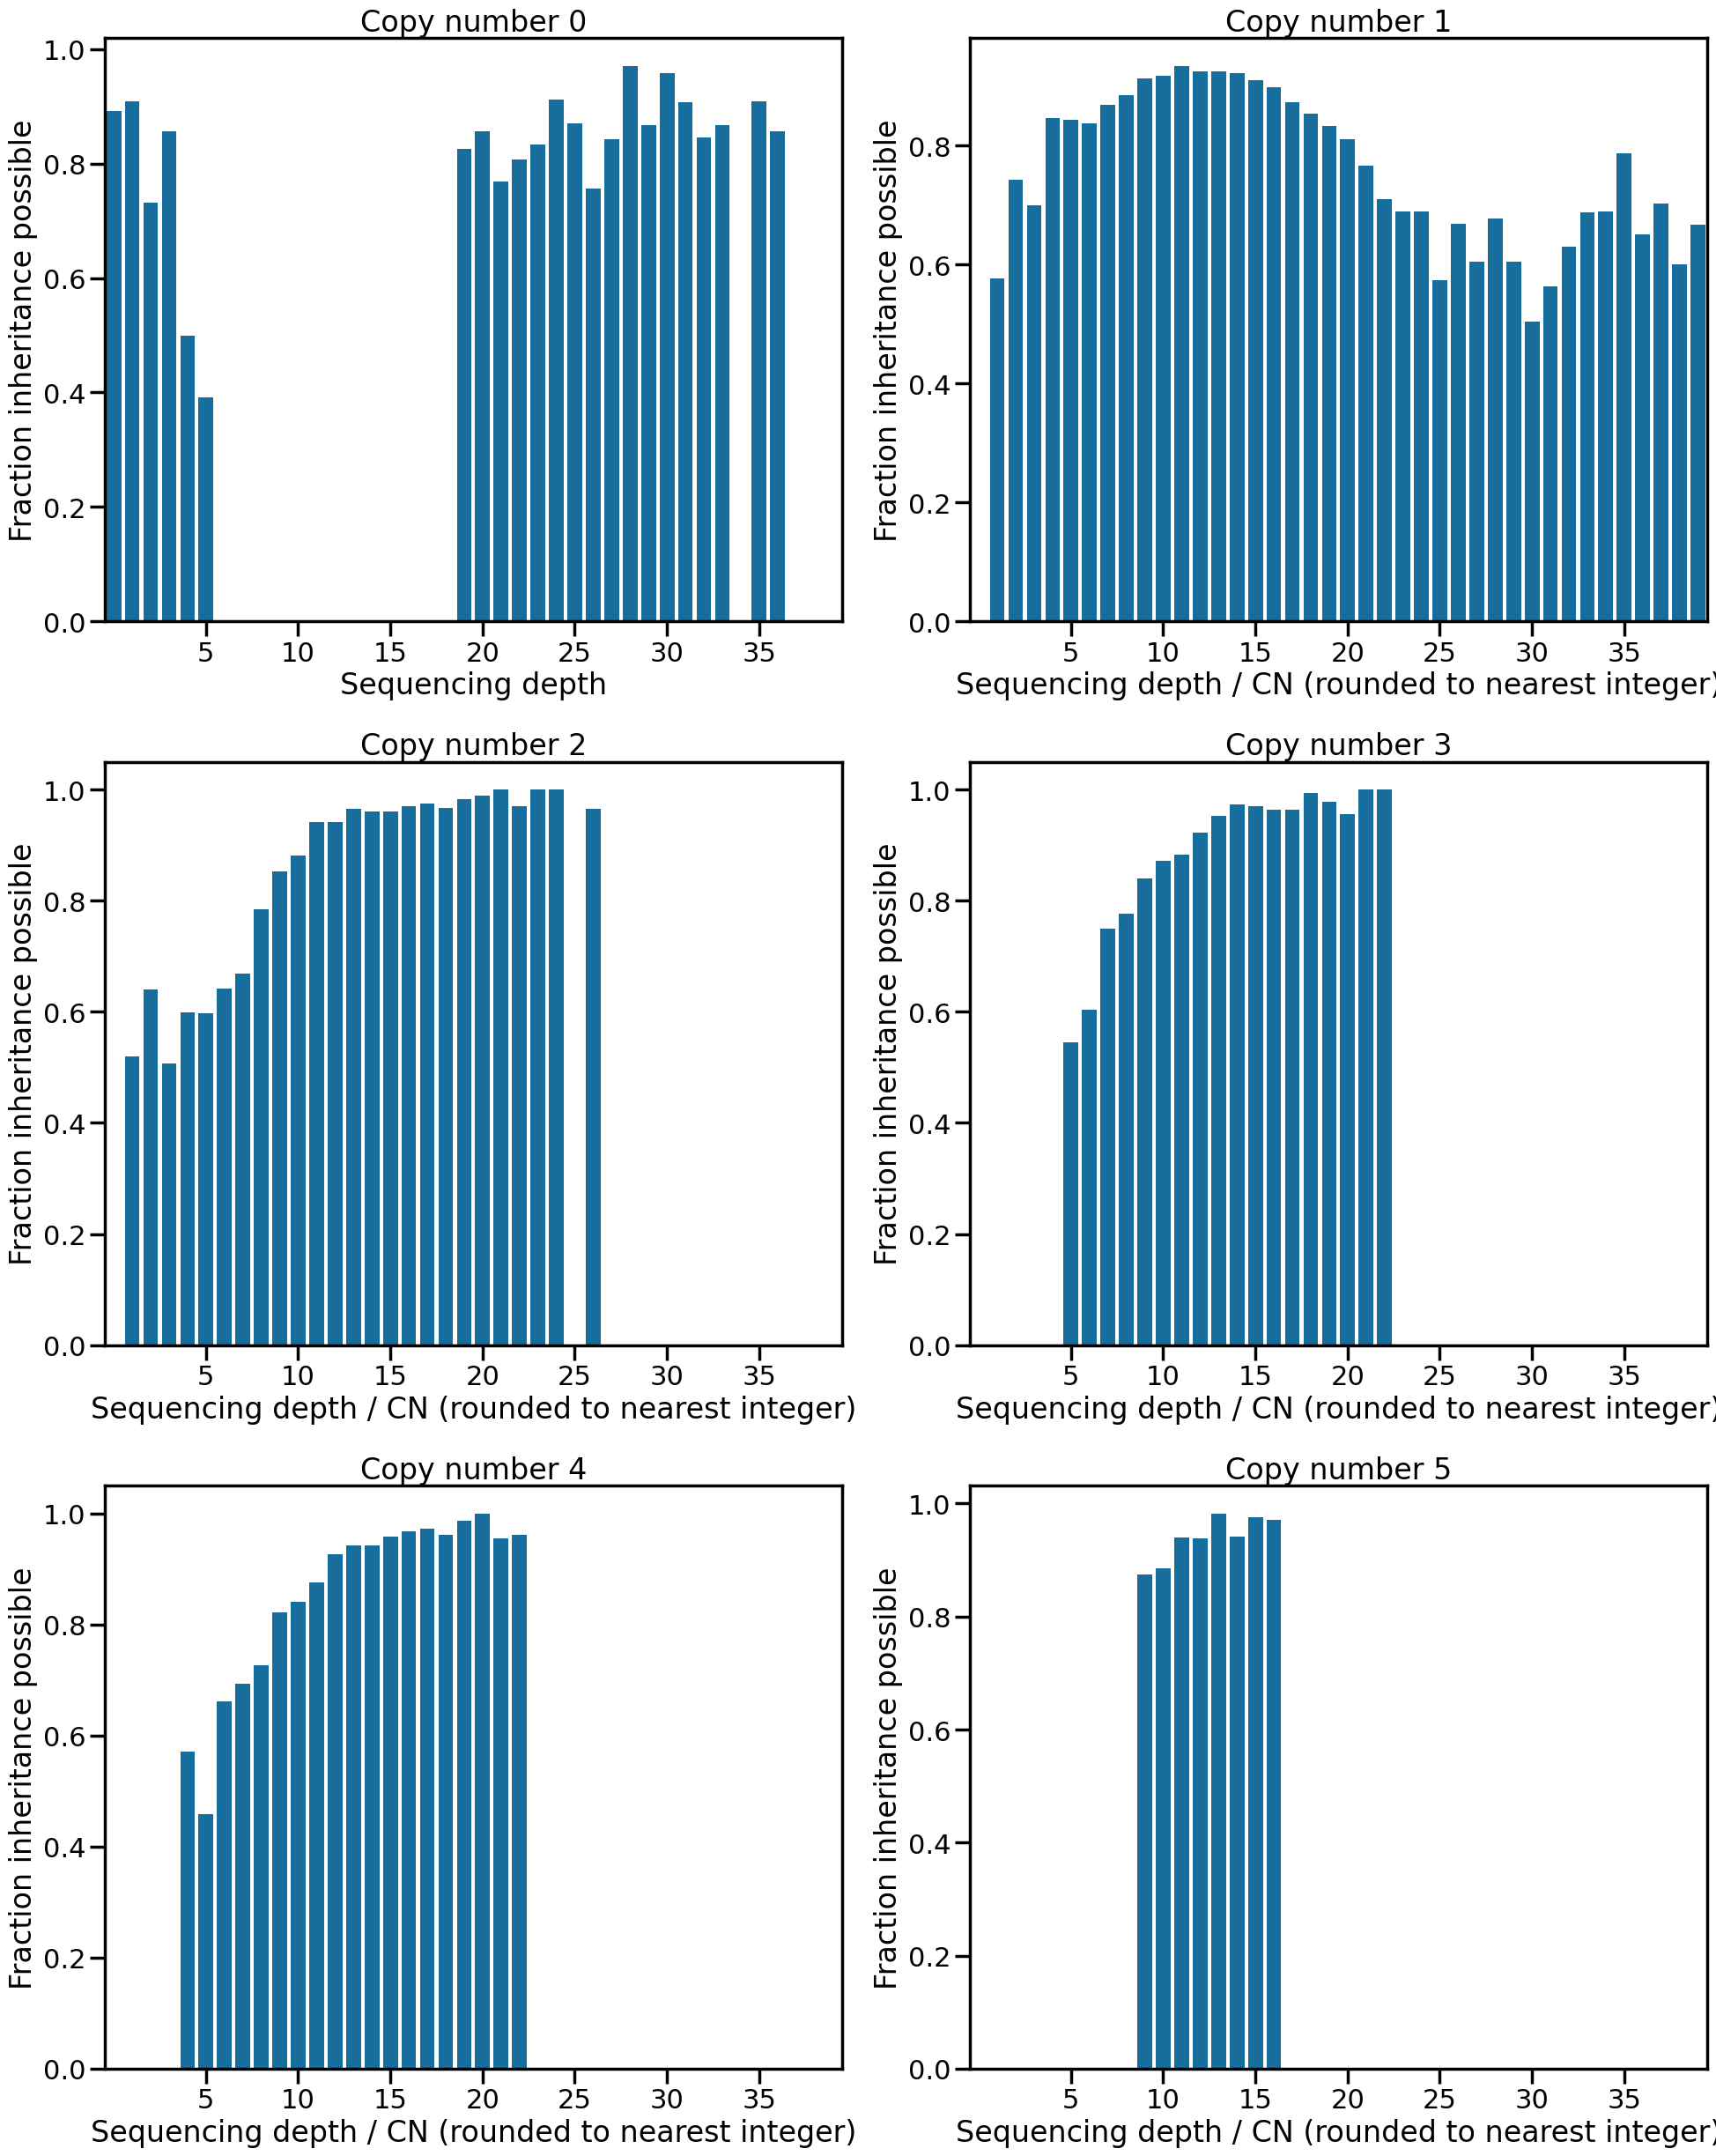

In [44]:
df_plot = (df_samples_filt
           .query("role == 'child' and copy_number >= 0 and copy_number <= 5")
           .assign(depth_per_cn_round = lambda x: x["depth_per_cn"].round(0).astype(int))[["copy_number", "depth_per_cn_round", "child_gt_possible"]]
           .groupby(["copy_number", "depth_per_cn_round"], as_index=False)
           .agg(n = ("child_gt_possible", "size"), frac = ("child_gt_possible", lambda x: sum(x) / len(x)))
           .query("n >= 20")
           .reset_index(drop=True))
x_order = pd.Categorical(np.arange(df_plot["depth_per_cn_round"].min(), df_plot["depth_per_cn_round"].max() + 1), ordered=True)

fig, axes = plt.subplots(3, 2, figsize=(20, 25))

for ax, (group, data) in zip(np.ravel(axes), df_plot.groupby("copy_number")):
    ax = sns.barplot(
        data,
        x="depth_per_cn_round",
        y="frac",
        order=x_order,
        ax=ax,
        color=sns.color_palette("colorblind")[0]
    )
    
    if group == 0:
        xlab = "Sequencing depth"
    else:
        xlab = "Sequencing depth / CN (rounded to nearest integer)"
    
    _ = ax.set(
        title=f"Copy number {group}",
        xticks = np.arange(5, max(ax.get_xticks()), 5),
        xlabel = xlab,
        # ylim=(0.45, 1.0),
        ylabel="Fraction inheritance possible"
    )

plt.tight_layout()

In [19]:
print(df_samples_filt.query("copy_number == 0").shape)
print(df_samples_filt.query("copy_number == 0 and depth <= 5").shape)
# df_samples_filt.query("copy_number == 0")["depth"].value_counts().head(20)

(12271, 10)
(9765, 10)


In [20]:
flank = 7.5

df_samples_filt = (df_samples_filt
                   .assign(dp_within_range = lambda x: [(15 - flank) < i < (15 + flank) for i in x["depth_per_cn"]])
                   .assign(dp_within_range = lambda x: [i < flank if j == 0 else l 
                                                        for i, j, l in zip(x["depth"], x["copy_number"], x["dp_within_range"])]))
df_samples_filt


total_loci = df_samples_filt.query("role == 'child'").shape[0]
within_range = df_samples_filt.query("dp_within_range and role == 'child'").shape[0]
consistent_loci = df_samples_filt.query("dp_within_range and child_gt_possible and role == 'child'").shape[0]

print(f"Loci where depth per CN was within range: {within_range} / {total_loci} ({within_range / total_loci * 100:.2f}%)")
print(f"{consistent_loci} out of {within_range} loci ({consistent_loci / within_range * 100:.2f}%) in the child could have possibly been inherited from the parents")

Loci where depth per CN was within range: 33875 / 40487 (83.67%)
31089 out of 33875 loci (91.78%) in the child could have possibly been inherited from the parents


In [21]:
min_depth_per_cn = 10
max_depth_per_cn = 21

print(f"{min_depth_per_cn} >= depth > {max_depth_per_cn}:")
total_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}").shape[0]
consistent_loci = df_samples_filt.query(f"role == 'child' and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn} and child_gt_possible").shape[0]
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")

10 >= depth > 21:
24670 out of 26417 loci (93.39%) in the child could have possibly been inherited from the parents


In [22]:
df_samples_consistent =  df_samples_filt.loc[df_samples_filt["child_gt_possible"]].reset_index(drop=True)
df_samples_consistent

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,dp_within_range
0,HG00421,chr1_1366512,1,{2: 45},[2],3,father,45,45.0,True,False
1,HG00422,chr1_1366512,1,{2: 32},[2],3,mother,32,32.0,True,False
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0,True,False
3,HG00421,chr1_4067034,2,{2: 25},"[2, 2]",3,father,25,12.5,True,True
4,HG00422,chr1_4067034,1,{2: 25},[2],3,mother,25,25.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
107626,NA19909,chrY_9809507,0,{},[],595,mother,0,0.0,True,True
107627,NA19919,chrY_9809507,0,{},[],595,child,0,0.0,True,True
107628,NA19908,chrY_10654069,2,{2: 42},"[2, 2]",595,father,42,21.0,True,True
107629,NA19909,chrY_10654069,0,{2: 36},[],595,mother,36,36.0,True,False


In [23]:
min_depth_per_cn = 10
max_depth_per_cn = 25
query_str = f"copy_number >= 3 and distinct_alleles >= 2 and period >= 2 and depth_per_cn >= {min_depth_per_cn} and depth_per_cn < {max_depth_per_cn}"

(df_samples_consistent
     .merge(df_repeats[["str_id", "unit", "period"]], on="str_id")
     .assign(
         distinct_alleles = lambda x: [len(set(i)) for i in x["genotype"]],
         depth_per_cn = lambda x: x["depth"] / x["copy_number"])
     .query(query_str))
     # .head(20))

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,dp_within_range,unit,period,distinct_alleles
3736,HG00422,chr1_183814198,3,"{7: 14, 8: 21}","[7, 8, 8]",3,mother,35,11.666667,True,True,AG,2,2
4482,HG00421,chr1_234782765,6,"{8: 38, 9: 21, 10: 20}","[8, 8, 8, 9, 9, 10]",3,father,79,13.166667,True,True,GT,2,3
4483,HG00422,chr1_234782765,7,"{8: 73, 9: 38, 10: 19}","[8, 8, 8, 8, 9, 9, 10]",3,mother,130,18.571429,True,True,GT,2,3
4484,HG00423,chr1_234782765,7,"{8: 37, 9: 28, 10: 30}","[8, 8, 8, 9, 9, 10, 10]",3,child,95,13.571429,True,True,GT,2,3
4485,HG00731,chr1_234782765,6,"{8: 45, 9: 34}","[8, 8, 8, 9, 9, 9]",55,father,79,13.166667,True,True,GT,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104601,NA19908,chr10_133562969,4,"{1: 22, 2: 60}","[1, 2, 2, 2]",595,father,82,20.500000,True,True,AGGCCA,6,2
104603,NA19919,chr10_133562969,4,"{1: 20, 2: 56}","[1, 2, 2, 2]",595,child,76,19.000000,True,True,AGGCCA,6,2
105008,NA19919,chr13_57247703,3,"{6: 14, 7: 25}","[6, 7, 7]",595,child,39,13.000000,True,True,TA,2,2
105369,NA19908,chr16_68760076,3,"{6: 26, 7: 1, 8: 17}","[6, 6, 8]",595,father,44,14.666667,True,True,AT,2,2


In [24]:
locus = "chr6_35792099"
df_samples_consistent.query(f"str_id == '{locus}'")

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,dp_within_range
19842,HG00731,chr6_35792099,5,"{6: 5, 7: 7, 8: 21}","[6, 7, 8, 8, 8]",55,father,33,6.600000,True,False
19843,HG00732,chr6_35792099,2,{7: 10},"[7, 7]",55,mother,10,5.000000,True,False
19844,HG00733,chr6_35792099,3,"{6: 15, 7: 10, 8: 9}","[6, 7, 8]",55,child,34,11.333333,True,True
48564,HG01884,chr6_35792099,4,"{6: 8, 7: 10, 8: 26}","[6, 7, 8, 8]",169,child,44,11.000000,True,True
48565,HG01885,chr6_35792099,4,"{6: 11, 7: 6, 8: 9}","[6, 6, 7, 8]",169,father,26,6.500000,True,False
48566,HG01956,chr6_35792099,2,"{6: 13, 8: 6}","[6, 8]",169,mother,19,9.500000,True,True
58392,HG02610,chr6_35792099,3,"{6: 11, 8: 13}","[6, 8, 8]",260,father,24,8.000000,True,True
58393,HG02611,chr6_35792099,4,"{6: 13, 7: 21, 8: 5}","[6, 7, 7, 8]",260,mother,39,9.750000,True,True
58394,HG02612,chr6_35792099,5,"{6: 15, 7: 16, 8: 12}","[6, 6, 7, 7, 8]",260,child,43,8.600000,True,True
70611,HG02952,chr6_35792099,3,"{6: 10, 7: 14, 8: 8}","[6, 7, 8]",320,mother,32,10.666667,True,True
